In [2]:
# !pip uninstall shapely -y
# !pip uninstall shapely -y
# !pip install shapely
# !pip install contextily

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
from datetime import datetime

import preprocessing_utils
import stgcn
import analysis as a

# Setup

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)

epochs = 500
batch_size = 50
lr = 0.001
patience = 10

num_timesteps_input = 12 # 60 minutes
num_timesteps_output = 6 # 30 minutes
loss_weights = [1,2,3,4,5,6]

raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

loss_weights_string = "".join([str(i) for i in loss_weights])
model_path = "./saved_models/{}in{}out{}.pt".format(num_timesteps_input, num_timesteps_output, loss_weights_string)

In [5]:
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, timestamps, means, stds = preprocessing_utils.load(process_dir)

In [6]:
data_chunks = preprocessing_utils.find_consecutive_chunks(timestamps, 9)
short_chunks = []
for i in range(len(data_chunks)):
    if len(data_chunks[i]) < num_timesteps_input + num_timesteps_output:
        short_chunks.append(i)
for idx in short_chunks[::-1]:
    del data_chunks[idx]
print(preprocessing_utils.chunk_len_proportion(data_chunks))

[0.029835702046164703, 0.12174175990323556, 0.005846184860397137, 0.00808386251385949, 0.0014313073278903337, 0.12029029331720592, 0.24372543090414273, 0.2543896784598327, 0.15244431004939019, 0.0212075395625441, 0.041003931055337166]


In [7]:
# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
training_input = torch.empty(0, X.shape[0], num_timesteps_input, X.shape[1])
training_target = torch.empty(0, X.shape[0], num_timesteps_output)
val_input = torch.empty(0, X.shape[0], num_timesteps_input, X.shape[1])
val_target = torch.empty(0, X.shape[0], num_timesteps_output)
test_input = torch.empty(0, X.shape[0], num_timesteps_input, X.shape[1])
test_target = torch.empty(0, X.shape[0], num_timesteps_output)
test_target_timestamps = []

train_count = 0
val_count = 0
test_count = 0
for i in range(len(data_chunks)):
    curr_input, curr_target = preprocessing_utils.generate_dataset(X[:,:,data_chunks[i]],
                                                           num_timesteps_input=num_timesteps_input,
                                                           num_timesteps_output=num_timesteps_output)
    if i < 7:
        training_input = torch.cat((training_input, curr_input))
        training_target = torch.cat((training_target, curr_target))
        train_count += len(data_chunks[i])
    elif i < 8:
        val_input = torch.cat((val_input, curr_input))
        val_target = torch.cat((val_target, curr_target))
        val_count += len(data_chunks[i])
    else:
        test_input = torch.cat((test_input, curr_input))
        test_target = torch.cat((test_target, curr_target))
        test_count += len(data_chunks[i])
        for j in range(num_timesteps_input, len(data_chunks[i]) - num_timesteps_output + 1):
            t = []
            for k in range(num_timesteps_output):
                key = str(data_chunks[i][j+k])
                t.append(datetime.strptime(timestamps[key], "%a_%b_%d_%Y_%H:%M:%S"))
            test_target_timestamps.append(t)
test_target_timestamps = np.array(test_target_timestamps)
print("Train Count: {}".format(train_count))
print("Val Count: {}".format(val_count))
print("Test Count: {}".format(test_count))
print("Train Samples: {}".format(training_input.shape[0]))
print("Val Samples: {}".format(val_input.shape[0]))
print("Test Samples: {}".format(test_input.shape[0]))

Train Count: 26338
Val Count: 12619
Test Count: 10648
Train Samples: 26219
Val Samples: 12602
Test Samples: 10597


In [8]:
def weighted_MSELoss(weights = []):
    def f(output, target):
        if len(weights) == 0:
            return nn.MSELoss()(output, target)
        total = torch.zeros(1).to(device) # [0]
        for i in range(len(weights)):
            total += nn.MSELoss()(output[:,:,i], target[:,:,i]) * weights[i]
        return total / sum(weights)
    return f

In [9]:
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).float()
adj_mat = adj_mat.to(device)

model = stgcn.STGCN(training_input.shape[1], training_input.shape[3], num_timesteps_input, num_timesteps_output)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = weighted_MSELoss(loss_weights)

In [10]:
def train_epoch():
    model.train()
    epoch_losses = []
    permutation = torch.randperm(training_input.shape[0])
    for i in range(0, training_input.shape[0], batch_size):
        optimizer.zero_grad()
        idxs = permutation[i:i+batch_size]
        batch_input = training_input[idxs].to(device)
        batch_target = training_target[idxs].to(device)
        output = model(adj_mat, batch_input)
        loss = criterion(output, batch_target)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        epoch_losses.append(batch_loss)
    return sum(epoch_losses) / len(epoch_losses)

def validate():
    val_losses = []
    with torch.no_grad():
        model.eval()
        for i in range(0, val_input.shape[0], batch_size):
            batch_input = val_input[i:i+batch_size].to(device)
            batch_target = val_target[i:i+batch_size].to(device)
            output = model(adj_mat, batch_input)
            loss = criterion(output, batch_target)
            val_losses.append(loss.item())
    return sum(val_losses) / len(val_losses)

def save_model():
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), model_path)
    
def test():
    preds = torch.empty((0, test_target.shape[1], test_target.shape[2]))
    actuals = torch.empty((0, test_target.shape[1], test_target.shape[2]))
    with torch.no_grad():
        model.eval()
        for i in range(0, test_input.shape[0], batch_size):
            batch_input = test_input[i:i+batch_size].to(device)
            actual = test_target[i:i+batch_size].cpu()
            actual = actual * stds[0] + means[0]
            actuals = torch.cat((actuals, actual))
            pred = model(adj_mat, batch_input).cpu()
            pred = pred * stds[0] + means[0]
            preds = torch.cat((preds, pred))
        return preds, actuals

# Training

In [10]:
train_losses = []
val_losses = []
curr_patience = patience
lowest_val_loss = float("inf")
for i in tqdm(range(epochs)):
    train_losses.append(train_epoch())
    val_losses.append(validate())
    
    if val_losses[-1] < lowest_val_loss:
        lowest_val_loss = val_losses[-1]
        curr_patience = patience
    else:
        curr_patience -= 1
        if curr_patience == 0:
            print("Early stopping activated after epoch {}".format(i+1))
            break

Early stopping activated after epoch 19



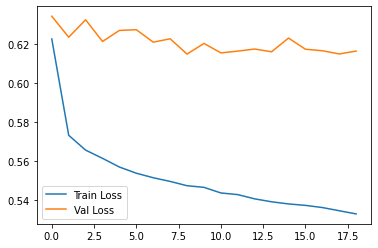

In [11]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

In [12]:
save_model()

# Analysis

In [11]:
model = stgcn.STGCN(training_input.shape[1], training_input.shape[3], num_timesteps_input, num_timesteps_output)
model.load_state_dict(torch.load(model_path))
model.to(device)
validate()

0.6162512819521984

In [12]:
pred, actual = test()

In [13]:
rmses = a.rmse_per_link(pred, actual)
rmses = np.array(rmses)
timestep_rmses = []
best_roads = []
worst_roads = []
for i in range(rmses.shape[1]):
    best_roads.append(np.argmin(rmses[:, i]))
    worst_roads.append(np.argmax(rmses[:, i]))
    timestep_rmses.append(np.mean(rmses[:, i]))
timestep_rmses

[0.6637003764791308,
 0.7434690521573121,
 0.7847783762329029,
 0.8032711811785428,
 0.8099620286023842,
 0.8137700400262509]

5 min worst road RMSE: 1.039551854133606
Weekday (Thu)


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


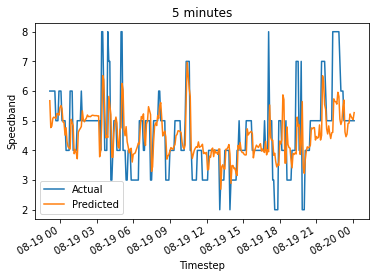

Weekend (Sat)


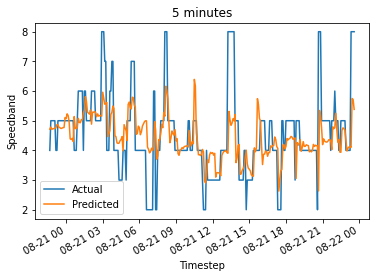

5 min best road RMSE: 0.3945580720901489
Weekday (Thu)


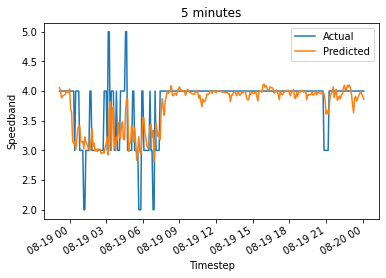

Weekend (Sat)


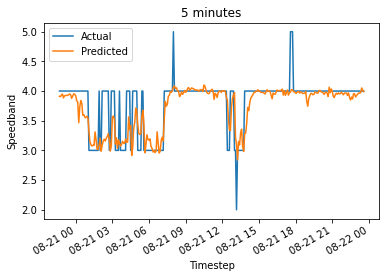

10 min worst road RMSE: 1.1680090427398682
Weekday (Thu)


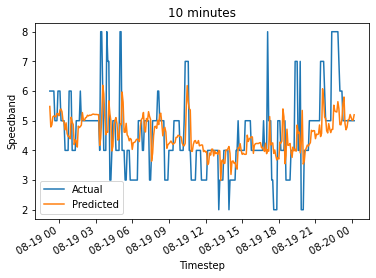

Weekend (Sat)


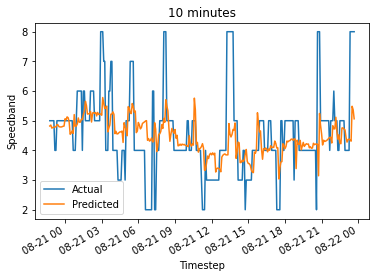

10 min best road RMSE: 0.4227430522441864
Weekday (Thu)


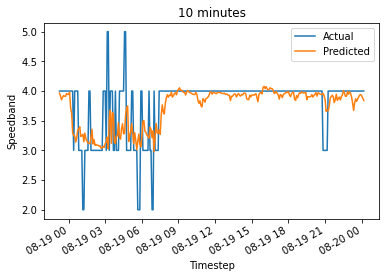

Weekend (Sat)


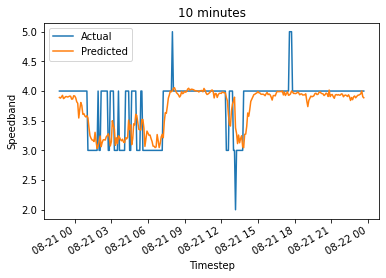

15 min worst road RMSE: 1.2302913665771484
Weekday (Thu)


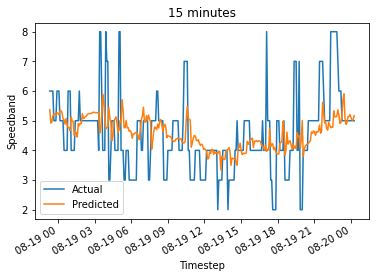

Weekend (Sat)


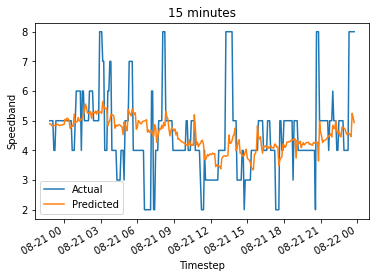

15 min best road RMSE: 0.43430477380752563
Weekday (Thu)


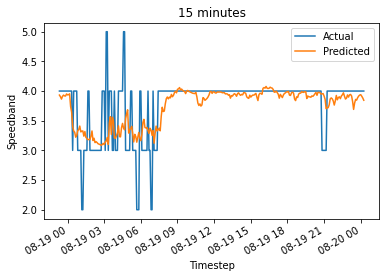

Weekend (Sat)


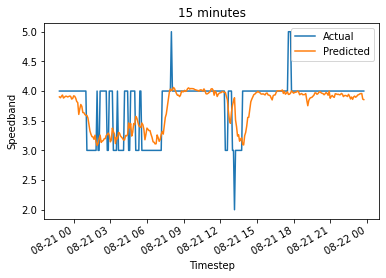

20 min worst road RMSE: 1.2549208402633667
Weekday (Thu)


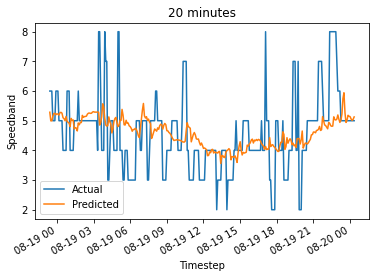

Weekend (Sat)


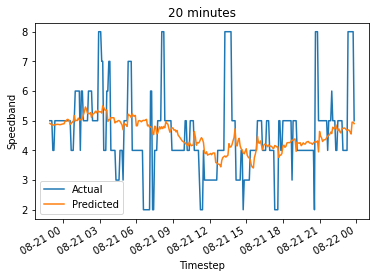

20 min best road RMSE: 0.44133642315864563
Weekday (Thu)


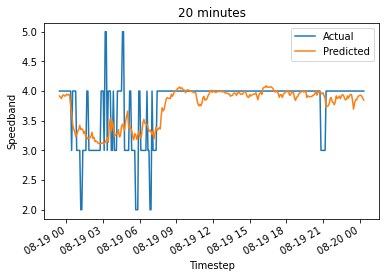

Weekend (Sat)


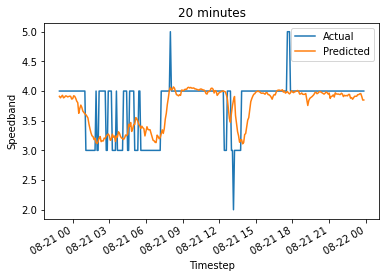

25 min worst road RMSE: 1.2606751918792725
Weekday (Thu)


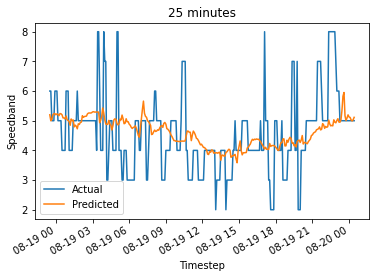

Weekend (Sat)


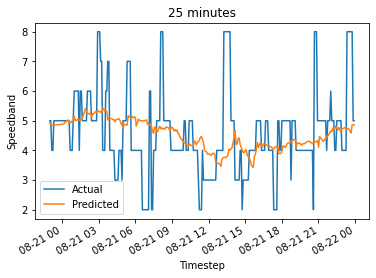

25 min best road RMSE: 0.4461860954761505
Weekday (Thu)


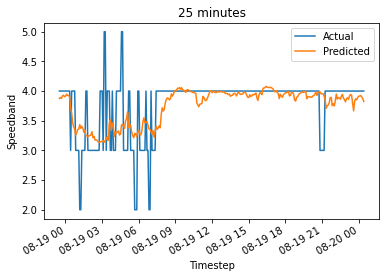

Weekend (Sat)


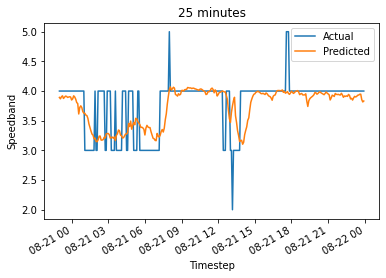

30 min worst road RMSE: 1.2631943225860596
Weekday (Thu)


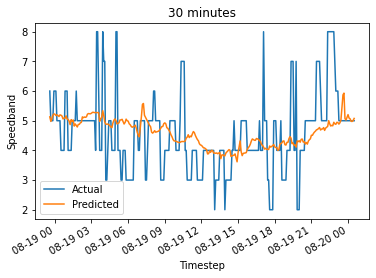

Weekend (Sat)


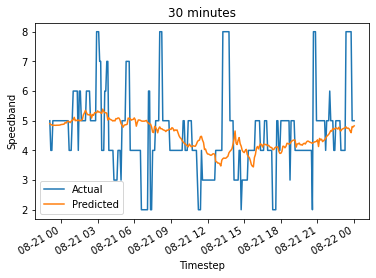

30 min best road RMSE: 0.4520563781261444
Weekday (Thu)


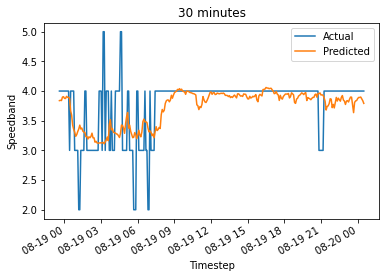

Weekend (Sat)


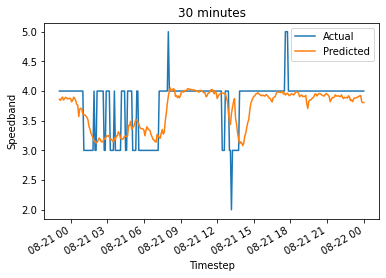

In [14]:
for i in range(len(timestep_rmses)):
    print("{} min worst road RMSE: {}".format((i+1)*5, rmses[worst_roads[i]][i]))
    print("Weekday (Thu)")
    a.plot_pred_actual(pred, actual, worst_roads[i], i, test_target_timestamps, (550, 850))
    print("Weekend (Sat)")
    a.plot_pred_actual(pred, actual, worst_roads[i], i, test_target_timestamps, (1120, 1420))
    print("{} min best road RMSE: {}".format((i+1)*5, rmses[best_roads[i]][i]))
    print("Weekday (Thu)")
    a.plot_pred_actual(pred, actual, best_roads[i], i, test_target_timestamps, (550, 850))
    print("Weekend (Sat)")
    a.plot_pred_actual(pred, actual, best_roads[i], i, test_target_timestamps, (1120, 1420))

In [17]:
# rmse_time = a.rmse_per_time(pred, actual, timestamps, timeidx = 0)
# a.plot_rmse_time(rmse_time[0], xlabel="Day of Week")
# rmse_time = a.rmse_per_time(pred, actual, timestamps, timeidx = 4)
# a.plot_rmse_time(rmse_time[0], xlabel="Hour of Day")